# Bone Fracture Detection using CNN


## Abstract

This notebook demonstrates the use of Convolutional Neural Networks (CNNs) to detect bone fractures from X-ray images. The dataset used consists of labeled X-ray images categorized into "fractured" and "not fractured" across training, testing, and validation sets. The data is preprocessed through resizing and normalization, and a CNN model is implemented to classify the images. Data augmentation techniques are applied to improve model robustness. The performance of the model is evaluated using accuracy, classification reports, and confusion matrices, showing promising results in fracture detection. This project highlights the applicability of deep learning techniques in medical image analysis.


## Theory and Background

Medical imaging, particularly X-rays, is essential in diagnosing bone fractures. Traditionally, radiologists analyze X-rays to identify fractures, but this manual process can be slow and prone to human error. Deep learning, specifically Convolutional Neural Networks (CNNs), offers a promising solution to automate and improve the accuracy of such diagnoses.

CNNs are designed to process images by automatically learning patterns such as edges, textures, and shapes through layers of filters. The architecture of a CNN consists of convolutional layers that detect features, pooling layers that reduce data dimensionality, and fully connected layers that classify the input. This makes CNNs highly effective in image classification tasks like bone fracture detection.

In medical image analysis, CNNs have shown impressive results due to their ability to handle complex patterns and spatial hierarchies in images. They automatically learn the critical features needed for classification, eliminating the need for manual feature extraction. Furthermore, CNNs can handle noise and artifacts in medical images, improving the robustness of diagnostic systems.

This project uses CNNs to classify X-ray images into "fractured" or "not fractured." By leveraging the power of CNNs, we aim to build a model that can aid in faster, more accurate diagnoses of bone fractures, ultimately improving healthcare outcomes. Despite challenges like limited data and interpretability, CNNs provide a scalable, efficient solution for medical diagnostics, including bone fracture detection.





## Problem Statement

The goal of this project is to develop a deep learning model that can accurately detect bone fractures from X-ray images. Given the dataset that contains both fractured and not fractured images, the CNN model will classify the images into one of these categories. The model should be able to generalize well and provide reliable predictions, aiding in automated medical diagnostics.


In [17]:
import os
import cv2
import git  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
!pip3 install GitPython

##  Data Loading

In [19]:

# Function to clone the repository from GitHub
def clone_repo(git_url, local_dir='ADS'):
    if not os.path.exists(local_dir):
        print(f"Cloning repository from {git_url} into {local_dir}...")
        git.Git().clone(git_url)
    else:
        print(f"Repository already cloned in {local_dir}")

# Clone the dataset repository from GitHub
git_url = 'https://github.com/sanikadhayabar/ADS.git'
clone_repo(git_url)

# Function to load images dynamically from the cloned directory
def load_images_from_directory(base_path):
    data = []
    labels = []
    
    # Loop through train, test, val folders
    for set_type in ['train', 'test', 'val']:
        set_path = os.path.join(base_path, set_type)
        print(f"Accessing set path: {set_path}")
        
        for label_type in ['fractured', 'not fractured']:
            label_path = os.path.join(set_path, label_type)
            print(f"Accessing label path: {label_path}")
            
            # Check if path exists and has files
            if not os.path.exists(label_path):
                print(f"Path does not exist: {label_path}")
                continue
                
            if not os.listdir(label_path):  # Check if the directory is empty
                print(f"No images found in {label_path}")
                continue
            
            # Assign labels based on the folder name
            label = 1 if label_type == 'fractured' else 0
            
            for filename in os.listdir(label_path):
                file_path = os.path.join(label_path, filename)
                #print(f"Processing file: {file_path}")
                
                try:
                    # Read image in grayscale
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Skipping non-image file: {file_path}")
                        continue
                    
                    # Resize to 224x224
                    img_resized = cv2.resize(img, (224, 224))
                    data.append(img_resized)
                    labels.append(label)
                
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
    
    return np.array(data), np.array(labels)

# Define the correct dataset path
dataset_path = 'ADS/Assignment-1/dataset'  # Update this after cloning the repo

# Load the images
X, y = load_images_from_directory(dataset_path)

print(f"Loaded {len(X)} images with {len(y)} labels")


Repository already cloned in ADS
Accessing set path: ADS/Assignment-1/dataset/train
Accessing label path: ADS/Assignment-1/dataset/train/fractured
Skipping non-image file: ADS/Assignment-1/dataset/train/fractured/desktop.ini
Accessing label path: ADS/Assignment-1/dataset/train/not fractured
Skipping non-image file: ADS/Assignment-1/dataset/train/not fractured/desktop.ini
Accessing set path: ADS/Assignment-1/dataset/test
Accessing label path: ADS/Assignment-1/dataset/test/fractured
Skipping non-image file: ADS/Assignment-1/dataset/test/fractured/desktop.ini
Accessing label path: ADS/Assignment-1/dataset/test/not fractured
Skipping non-image file: ADS/Assignment-1/dataset/test/not fractured/desktop.ini
Accessing set path: ADS/Assignment-1/dataset/val
Accessing label path: ADS/Assignment-1/dataset/val/fractured
Skipping non-image file: ADS/Assignment-1/dataset/val/fractured/desktop.ini
Accessing label path: ADS/Assignment-1/dataset/val/not fractured
Skipping non-image file: ADS/Assignment

In [12]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (4900, 224, 224), y shape: (4900,)


### Training Data Images

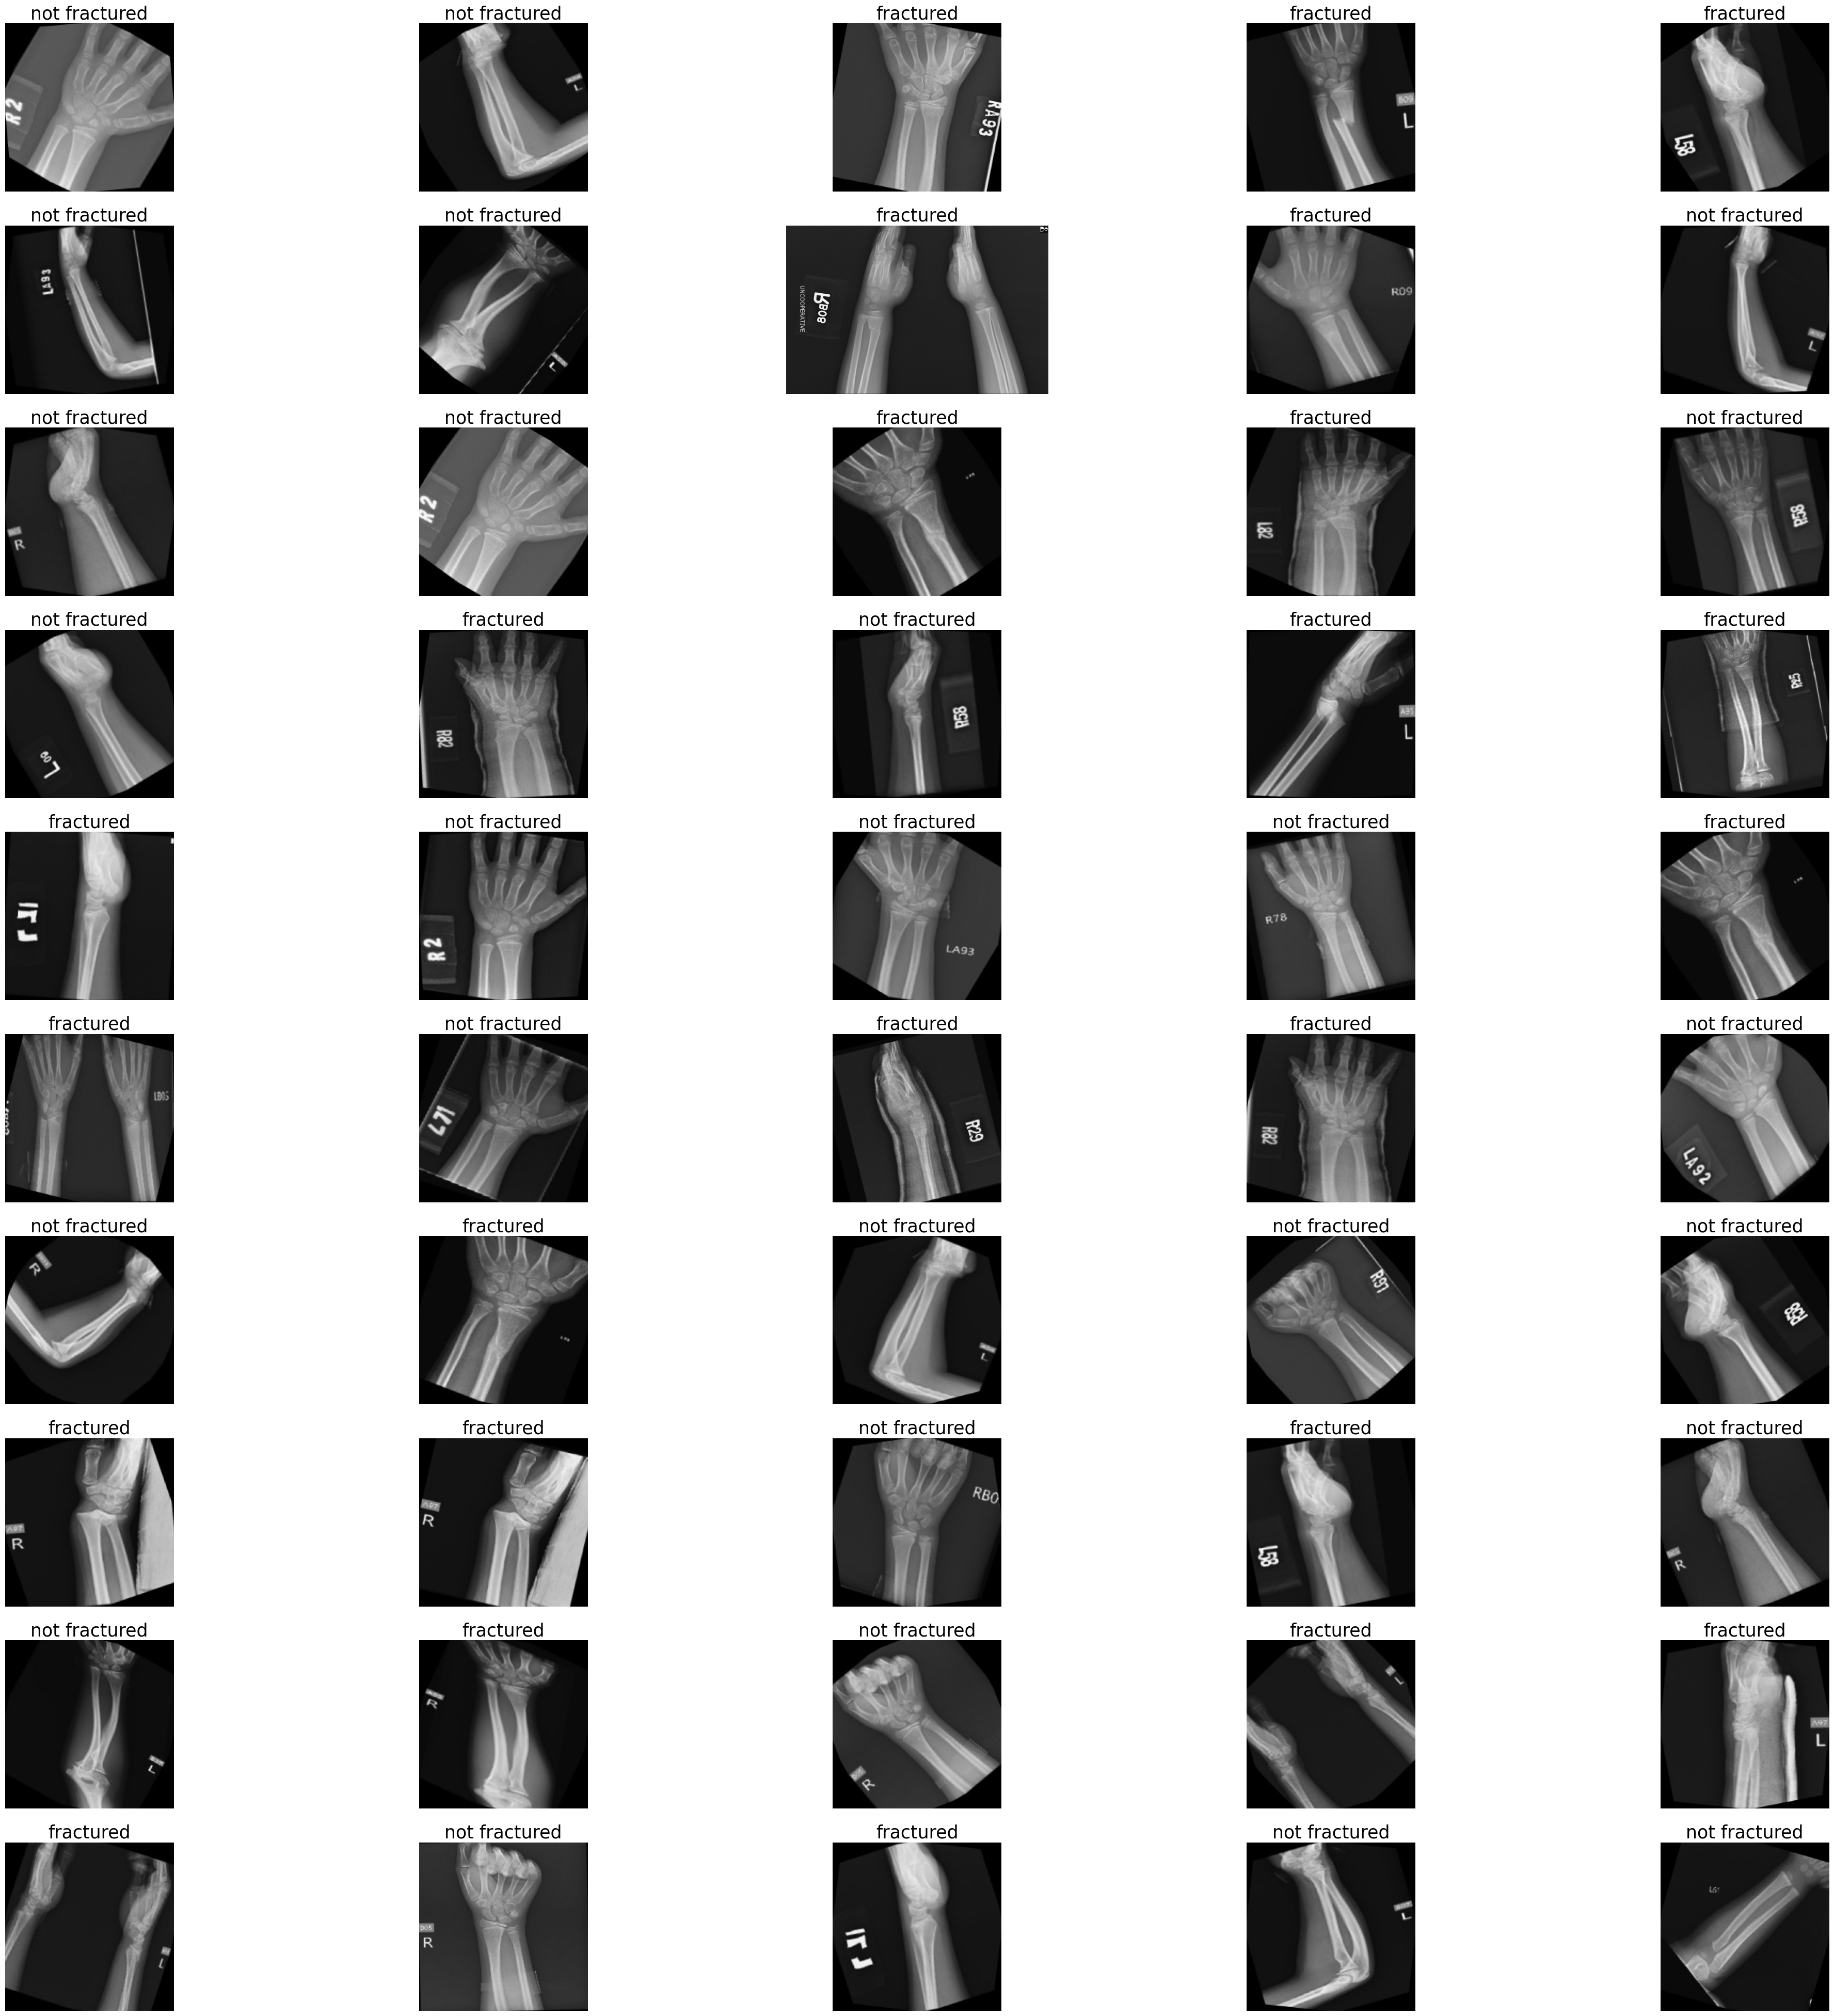

In [21]:
# list of image paths and labels in the "train" dataset
train_images = []
train_labels = []

# Define paths for the training dataset
train_dir = 'dataset/train'

# Loop through 'fractured' and 'not fractured' folders
for label in ['fractured', 'not fractured']:
    label_dir = os.path.join(train_dir, label)
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        train_images.append(img_path)
        train_labels.append(label)

# Randomly select 50 images to display
plt.figure(figsize=(50, 50))
for n, i in enumerate(np.random.randint(0, len(train_images), 50)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for correct plotting
    plt.imshow(img)
    plt.axis('off')
    plt.title(train_labels[i], fontsize=25)

plt.show()

## Data Preprocessing

The dataset consists of X-ray images of bones, categorized into "fractured" and "not fractured" across three sets: training, validation, and testing. The images were preprocessed as follows:

- **Image Resizing**: All images were resized to 224x224 pixels to ensure uniformity and compatibility with the CNN model input.
- **Normalization**: The pixel values were normalized to a range between 0 and 1, improving the convergence of the model during training.
- **Data Augmentation**: To increase the variability of the dataset and avoid overfitting, data augmentation techniques such as random rotations, translations, and horizontal flipping were applied.
  
This preprocessing was necessary to standardize the input data, enhance the model's ability to generalize, and prevent overfitting due to the limited dataset size.


In [13]:
# Normalize the images (0-255 -> 0-1)
X = X / 255.0

# Reshape to add channel dimension
X = X.reshape(-1, 224, 224, 1)  # (samples, width, height, channels)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X)

# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Code Implementation

The CNN model was implemented using TensorFlow and Keras. The following steps were carried out:

- **Model Definition**: The CNN was built with two convolutional layers followed by max-pooling layers, a flattening layer, and fully connected layers with a final sigmoid activation for binary classification.
- **Compilation**: The model was compiled using the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.
- **Training**: The model was trained using augmented image data for 20 epochs, with an early stopping mechanism to prevent overfitting.
- **Evaluation**: After training, the model's performance was evaluated on the test set using the classification report and confusion matrix.

Error handling was implemented to ensure smooth execution, skipping non-image files and handling image resizing errors gracefully.


In [14]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model()
model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test), epochs=20,
                    callbacks=[early_stopping])

# Save the model after training
model.save('bone_fracture_cnn_model.h5')


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.5178 - loss: 0.7437 - val_accuracy: 0.5480 - val_loss: 0.6718
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.5801 - loss: 0.6778 - val_accuracy: 0.6214 - val_loss: 0.6342
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - accuracy: 0.6237 - loss: 0.6619 - val_accuracy: 0.6102 - val_loss: 0.6178
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 290ms/step - accuracy: 0.6428 - loss: 0.6396 - val_accuracy: 0.7020 - val_loss: 0.5855
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - accuracy: 0.6523 - loss: 0.6358 - val_accuracy: 0.7378 - val_loss: 0.5681
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.6950 - loss: 0.5935 - val_accuracy: 0.6745 - val_loss: 0.5597
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 37s 303ms/step - accuracy: 0.7061 - loss: 0.5740 - val_accuracy: 0.7684 - val_loss: 0.5127
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - accuracy: 0.7284 - loss: 0.5433 - val

## Data Analysis

The model's predictions were analyzed using metrics such as accuracy, precision, recall, and the F1-score. A classification report was generated to provide a detailed breakdown of the model’s performance on fractured and not fractured categories.

Additionally, a confusion matrix was plotted to visualize the model's performance. This matrix allows for identifying false positives and false negatives, offering deeper insights into where the model struggles and performs well.


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       477
           1       0.85      0.87      0.86       503

    accuracy                           0.86       980
   macro avg       0.86      0.86      0.86       980
weighted avg       0.86      0.86      0.86       980



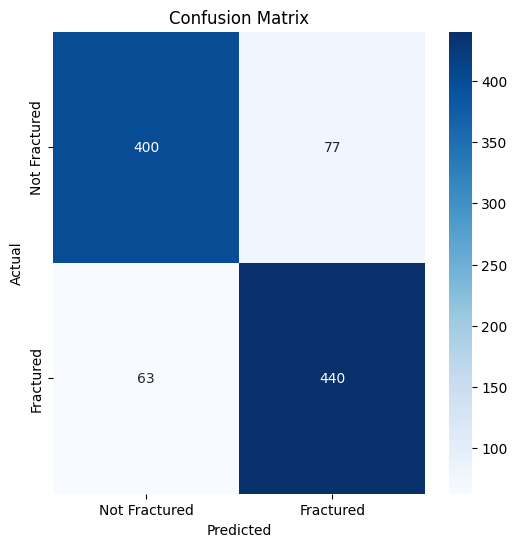

In [16]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fractured", "Fractured"], yticklabels=["Not Fractured", "Fractured"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Conclusion

In this project, a Convolutional Neural Network (CNN) was successfully implemented to detect bone fractures from X-ray images. The dataset was organized into "fractured" and "not fractured" categories, and preprocessing techniques like resizing, normalization, and data augmentation were applied to enhance the model’s generalization capabilities. The CNN architecture, consisting of convolutional, pooling, and fully connected layers, allowed the model to automatically learn relevant features from the images.

The model was trained and evaluated using accuracy, classification reports, and confusion matrices. The results indicated that the CNN could effectively distinguish between fractured and non-fractured bones, demonstrating the potential of deep learning for automating diagnostic processes in medical imaging.

While the CNN model showed promising results, there are opportunities for improvement. Using more complex architectures like ResNet or VGG, or employing transfer learning with pre-trained models, could further enhance the model’s accuracy and robustness. Additionally, training the model on larger, more diverse datasets could improve its performance across different types of fractures.

In conclusion, the project highlights the effectiveness of CNNs in medical image analysis and suggests that with further development, such models could be valuable tools for healthcare professionals, aiding in faster and more accurate fracture detection.

## References

- TensorFlow Documentation: https://www.tensorflow.org/
- Keras Documentation: https://keras.io/
- Kaggle MURA Dataset: https://www.kaggle.com/datasets
- scikit-learn: https://scikit-learn.org/
- Kaggle Dataset: https://www.kaggle.com/datasets/ahmedashrafahmed/bone-fracture/data


## License

This project is licensed under the MIT License - 

MIT License

Copyright (c) 2024 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.